In [1]:
# 4. Project prototype (implementation)
## Install Dependencies and import libraries

# pip install pandas numpy yfinance pandas-ta scikit-learn tensorflow

# https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)
# import yfinance, our data source
import yfinance as yf

# https://pypi.org/project/pandas-ta/ ("""An easy to use Python 3 Pandas Extension with 130+ Technical Analysis Indicators. Can be called from a Pandas DataFrame or standalone""")
# import pandas-ta
import pandas_ta as ta

# import pandas and numpy
import pandas as pd 
import numpy as np

# import matplotlib for data visualisation
import matplotlib.pyplot as plt

# import from scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# import from tensorflow
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Input, GRU, SeparableConv1D, BatchNormalization, MaxPooling1D, add, Layer, concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from keras_tuner import HyperModel, Hyperband, Tuner, Oracle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from datetime import datetime


# Load Data

In [2]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

# define a function to load the data from source (yfinance API), and save it as a csv to local storage
def loadData(symbols=symbols_list, period='max', interval='1wk'):
    
    try:
        # load the the dataframe from the csv file if it already exist
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv').set_index(['Date', 'Ticker'])
        
        print("Data loaded from directory")
        
    except FileNotFoundError:
        # print a message stating the data does not already exists and need to be downloaded from yfinance
        print(f"There is no {period}_{interval}_stocks_data.csv. Data will be downloaded from yfinance.")
        
        # download the data from source and store it in the stock_data variable which will hold the data as a pandas dataframe
        stocks_data =  yf.download(symbols, period=period, interval=interval)

        # reshape the dataframe as a multi-level index dataframe
        stocks_data = stocks_data.stack()

        # source: https://www.statology.org/pandas-change-column-names-to-lowercase/
        # convert column names to lowercase
        stocks_data.columns = stocks_data.columns.str.lower()

        # save the dataframe to a csv file (Save the data to a CSV so we don't have to make any extra unnecessary requests to the API every time we reload the notebook)
        stocks_data.to_csv(f'{period}_{interval}_stocks_data.csv', index=True)

        # load the the dataframe from the csv file
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv').set_index(['Date', 'Ticker'])

    finally: 
        # create a dict to store the dataframe of each unique symbol where keys are symbol, values are dataframes
        df_dict = {}

        # iterate over the symbols
        for symbol in symbols:

            # source of inspiration https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html [11]
            # extract the specific stock data at the 'Ticker' level of this multi index dataframe and save it as a dataframe
            symbol_df = df.xs(symbol, axis=0, level='Ticker', drop_level=True)

            # store the datafram into the df_dict
            df_dict[symbol] = symbol_df

        # return the dictionary
        return df_dict


dfs = loadData()

Data loaded from directory


In [3]:
dfs[symbols_list[0]]

,adj close,close,high,low,open,volume
Date,,,,,,
1972-05-29,0.159691,0.805463,0.817817,0.802993,0.815346,4072656.0
1972-06-05,0.162630,0.820288,0.825229,0.798051,0.805463,8595581.0
1972-06-12,0.165569,0.835112,0.837583,0.810405,0.820288,11312372.0
1972-06-19,0.166549,0.840054,0.854878,0.820288,0.835112,9986861.0
1972-06-26,0.166059,0.837583,0.849937,0.817817,0.840054,9025613.0
...,...,...,...,...,...,...
2024-07-15,29.552921,29.969999,30.690001,28.830000,29.030001,180142400.0
2024-07-22,30.341789,30.770000,30.930000,29.309999,30.110001,179544200.0
2024-07-29,30.430000,30.430000,31.540001,29.780001,30.690001,254667700.0


# Add Targets

In [4]:
# create a function that takes a dataframe and create 'next_close' column based on its 'close' column
def get_next_close(_df):
    
    # create the 'next_close' column to be equal to the next closing price
    # this can be accomplished easily by shifting the close column backward by 1
    return _df['close'].shift(-1)

# create a function that returns 1 if the the next closing price is higher than current closing price and 0 otherwise.
def assign_trend(row):
    if row['next_close'] > row['close']:
        return 1
    elif row['next_close'] < row['close']:
        return 0
    else: # if the next value is missing then return NaN
        return np.nan

# create a function that add the target columns to the dataframe
def add_targets(_df):
    
    # add the next_close column to the dataframe
    _df['next_close'] = get_next_close(_df)
    
    # add the trend column to the dataframe
    _df['trend'] = _df.apply(assign_trend, axis=1)
    
    # drop the NaN values
    _df.dropna(inplace=True)
    
    # fix the 'trend' data type to be int
    _df = _df.astype({'trend': int})
    
    return _df

# add target columns to all the data frames
# df = add_targets(dfs[symbols_list[0]])
# df

# Features Selection

In [5]:
#  we can easily check the available indicators in the pandas-ta library
# help(df.ta.indicators())

In [6]:
# help(ta.donchian)
# df.ta.donchian()

65 different technical indicators columns were added in this function.

In [7]:
# for the time being let's create a function that add all the technical indicators we want to a df
def add_technical_indicators(_df):
    
    ##### indicators based on the closing price ##### index range: 6:36
    # apply macd on the close column in a df and add it to the dataframe    
    macd = ta.macd(_df['close'])
    # The MACD (Moving Average Convergence/Divergence) is a popular indicator to that is used to identify a trend
    _df.insert(6, 'macd', macd.iloc[:,0])
    # Histogram is the difference of MACD and Signal
    _df.insert(7, 'macd_histogram', macd.iloc[:,1])
    # Signal is an EMA (exponential moving average) of MACD
    _df.insert(8, 'macd_signal', macd.iloc[:,2])
    
    # apply RSI on the Close column in a df and add it to the dataframe    
    # RSI (Relative Strength Index) is popular momentum oscillator. Measures velocity and magnitude a trend
    rsi = ta.rsi(_df['close'])
    _df.insert(9, 'rsi', rsi)

    # apply SMA on the Close column in a df and add it to the dataframe    
    # SMA (Simple Moving Average) is the classic moving average that is the equally weighted average over n periods.
    sma = ta.sma(_df['close'])
    _df.insert(10, 'sma', sma)

    # apply EMA on the Close column in a df and add it to the dataframe    
    # EMA (Exponential Moving Average). The weights are determined by alpha which is proportional to it's length.
    ema = ta.ema(_df['close'])
    _df.insert(11, 'ema', ema)
    
    ######## repeat the same proccess for all the technical indicators we want to include ##########
    # bbands: A popular volatility indicator by John Bollinger.
    bbands = ta.bbands(_df['close'])
    _df.insert(12, 'bbands_lower', bbands.iloc[:,0])
    _df.insert(13, 'bbands_mid', bbands.iloc[:,1])
    _df.insert(14, 'bbands_upper', bbands.iloc[:,2])
    _df.insert(15, 'bbands_bandwidth', bbands.iloc[:,3])
    _df.insert(16, 'bbands_percent', bbands.iloc[:,4])
    
    # dema: The Double Exponential Moving Average attempts to a smoother average with less lag than the normal Exponential Moving Average (EMA).
    dema = ta.dema(_df['close'])
    _df.insert(17, 'dema', dema)
    
    # tema: A less laggy Exponential Moving Average.
    tema = ta.tema(_df['close'])
    _df.insert(18, 'tema', tema)

    # roc: Rate of Change is an indicator is also referred to as Momentum. It is a pure momentum oscillator that measures the percent change in price with the previous price 'n' (or length) periods ago.
    roc = ta.roc(_df['close'])
    _df.insert(19, 'roc', roc)
    
    # mom: Momentum is an indicator used to measure a security's speed (or strength) of movement.  Or simply the change in price.
    mom = ta.mom(_df['close'])
    _df.insert(20, 'mom', mom)
    
    # kama: Developed by Perry Kaufman, Kaufman's Adaptive Moving Average (KAMA) is a moving average designed to account for market noise or volatility. KAMA will closely follow prices when the price swings are relatively small and the noise is low. KAMA will adjust when the price swings widen and follow prices from a greater distance. This trend-following indicator can be used to identify the overall trend, time turning points and filter price movements.
    kama = ta.kama(_df['close'])
    _df.insert(21, 'kama', kama)
                       
    # trix: is a momentum oscillator to identify divergences.
    trix = ta.trix(_df['close'])
    _df.insert(22, 'trix', trix.iloc[:,0])
    _df.insert(23, 'trixs', trix.iloc[:,1])
    
    # hma: The Hull Exponential Moving Average attempts to reduce or remove lag in moving averages.
    hma = ta.hma(_df['close'])
    _df.insert(24, 'hma', hma)
    
    # alma: The ALMA moving average uses the curve of the Normal (Gauss) distribution, which can be shifted from 0 to 1. This allows regulating the smoothness and high sensitivity of the indicator. Sigma is another parameter that is responsible for the shape of the curve coefficients. This moving average reduces lag of the data in conjunction with smoothing to reduce noise.
    alma = ta.alma(_df['close'])
    _df.insert(25, 'alma', alma)
    
    # apo: The Absolute Price Oscillator is an indicator used to measure a security's momentum.  It is simply the difference of two Exponential Moving Averages (EMA) of two different periods. Note: APO and MACD lines are equivalent.
    apo = ta.apo(_df['close'])
    _df.insert(26, 'apo', apo)
    
    # cfo: The Forecast Oscillator calculates the percentage difference between the actualprice and the Time Series Forecast (the endpoint of a linear regression line).
    cfo = ta.cfo(_df['close'])
    _df.insert(27, 'cfo', cfo)
    
    # cg: The Center of Gravity Indicator by John Ehlers attempts to identify turning points while exhibiting zero lag and smoothing.
    cg = ta.cg(_df['close'])
    _df.insert(28, 'cg', cg)
    
    # cmo: Attempts to capture the momentum of an asset with overbought at 50 and oversold at -50.
    cmo = ta.cmo(_df['close'])
    _df.insert(29, 'cmo', cmo)
    
    # coppock: Coppock Curve (originally called the "Trendex Model") is a momentum indicator is designed for use on a monthly time scale.  Although designed for monthly use, a daily calculation over the same period can be made, converting the periods to 294-day and 231-day rate of changes, and a 210-day weighted moving average.
    coppock = ta.coppock(_df['close'])
    _df.insert(30, 'coppock', coppock)
    
    # cti: The Correlation Trend Indicator is an oscillator created by John Ehler in 2020. It assigns a value depending on how close prices in that range are to following a positively- or negatively-sloping straight line. Values range from -1 to 1. This is a wrapper for ta.linreg(close, r=True).
    cti = ta.cti(_df['close'])
    _df.insert(31, 'cti', cti)
    
    # decay: Creates a decay moving forward from prior signals like crosses. The default is "linear". Exponential is optional as "exponential" or "exp".
    decay = ta.decay(_df['close'])
    _df.insert(32, 'decay', decay)
    
    # decreasing: Returns True if the series is decreasing over a period, False otherwise. If the kwarg 'strict' is True, it returns True if it is continuously decreasing over the period. When using the kwarg 'asint', then it returns 1 for True or 0 for False.
    decreasing = ta.decreasing(_df['close'])
    _df.insert(33, 'decreasing', decreasing)
    
    # ebsw: This indicator measures market cycles and uses a low pass filter to remove noise. Its output is bound signal between -1 and 1 and the maximum length of a detected trend is limited by its length input.
    ebsw = ta.ebsw(_df['close'])
    _df.insert(34, 'ebsw', ebsw)
    
    # entropy: Introduced by Claude Shannon in 1948, entropy measures the unpredictability of the data, or equivalently, of its average information. A die has higher entropy (p=1/6) versus a coin (p=1/2).
    entropy = ta.entropy(_df['close'])
    _df.insert(35, 'entropy', entropy)
    
    
    ##### indicators based on the high and lows of the price ##### range= 36:67
    
    # aberration: A volatility indicator
    aberration = ta.aberration(_df['high'], _df['low'], _df['close'])
    _df.insert(36, 'aberration_zg', aberration.iloc[:,0])
    _df.insert(37, 'aberration_sg', aberration.iloc[:,1])
    _df.insert(38, 'aberration_xg', aberration.iloc[:,2])
    _df.insert(39, 'aberration_atr', aberration.iloc[:,3])
    
    # adx:  Average Directional Movement is meant to quantify trend strength by measuring the amount of movement in a single direction.    
    adx = ta.adx(_df['high'], _df['low'], _df['close'])
    _df.insert(40, 'adx_adx', adx.iloc[:,0])
    _df.insert(41, 'adx_dmp', adx.iloc[:,1])
    _df.insert(42, 'adx_dmn', adx.iloc[:,2])

    # atr: Averge True Range is used to measure volatility, especially volatility caused by gaps or limit moves.
    atr = ta.atr(_df['high'], _df['low'], _df['close'])
    _df.insert(43, 'atr', atr)
    
    # stoch: The Stochastic Oscillator (STOCH) was developed by George Lane in the 1950's. He believed this indicator was a good way to measure momentum because changes in momentum precede changes in price.
    stoch = ta.stoch(_df['high'], _df['low'], _df['close'])
    _df.insert(44, 'stoch_k', stoch.iloc[:,0])
    _df.insert(45, 'stoch_d', stoch.iloc[:,1])
    
    # Supertrend: is an overlap indicator. It is used to help identify trend direction, setting stop loss, identify support and resistance, and/or generate buy & sell signals.
    supertrend = ta.supertrend(_df['high'], _df['low'], _df['close'])
    _df.insert(46, 'supertrend_trend', supertrend.iloc[:,0])
    _df.insert(47, 'supertrend_direction', supertrend.iloc[:,1])
    
    # cci: Commodity Channel Index is a momentum oscillator used to primarily identify overbought and oversold levels relative to a mean.
    cci = ta.cci(_df['high'], _df['low'], _df['close'])
    _df.insert(48, 'cci', cci)
    
    # aroon: attempts to identify if a security is trending and how strong.
    aroon = ta.aroon(_df['high'], _df['low'])
    _df.insert(49, 'aroon_up', aroon.iloc[:,0])
    _df.insert(50, 'aroon_down', aroon.iloc[:,1])
    _df.insert(51, 'aroon_osc', aroon.iloc[:,2])
    
    # natr: Normalized Average True Range attempt to normalize the average true range.
    natr = ta.natr(_df['high'], _df['low'], _df['close'])
    _df.insert(52, 'natr', natr)
    
    # William's Percent R is a momentum oscillator similar to the RSI that attempts to identify overbought and oversold conditions.
    willr = ta.willr(_df['high'], _df['low'], _df['close'])
    _df.insert(53, 'willr', willr)
    
    # vortex: Two oscillators that capture positive and negative trend movement.
    vortex = ta.vortex(_df['high'], _df['low'], _df['close'])
    _df.insert(54, 'vortex_vip', vortex.iloc[:,0])
    _df.insert(55, 'vortex_vim', vortex.iloc[:,1])
    
    # hlc3: the average of high, low, and close prices
    hlc3 = ta.hlc3(_df['high'], _df['low'], _df['close'])
    _df.insert(56, 'hlc3', hlc3)
    
    # ohlc4: the average of open, high, low, and close prices
    ohlc4 = ta.ohlc4(_df['open'], _df['high'], _df['low'], _df['close'])
    _df.insert(57, 'ohlc4', ohlc4)
    
    # accbands: Acceleration Bands created by Price Headley plots upper and lower envelope bands around a simple moving average.
    accbands = ta.accbands(_df['high'], _df['low'], _df['close'])
    _df.insert(58, 'accbands_lower', accbands.iloc[:,0])
    _df.insert(59, 'accbands_mid', accbands.iloc[:,1])
    _df.insert(60, 'accbands_upper', accbands.iloc[:,2])

    # chop: The Choppiness Index was created by Australian commodity trader E.W. Dreiss and is designed to determine if the market is choppy (trading sideways) or not choppy (trading within a trend in either direction). Values closer to 100 implies the underlying is choppier whereas values closer to 0 implies the underlying is trending.
    chop = ta.chop(_df['high'], _df['low'], _df['close'])
    _df.insert(61, 'chop', chop)
    
    # dm: The Directional Movement was developed by J. Welles Wilder in 1978 attempts to determine which direction the price of an asset is moving. It compares prior highs and lows to yield to two series +DM and -DM.
    dm = ta.dm(_df['high'], _df['low'])
    _df.insert(62, 'dm_positive', dm.iloc[:,0])
    _df.insert(63, 'dm_negative', dm.iloc[:,1])

    # donchian: Donchian Channels are used to measure volatility, similar to Bollinger Bands and Keltner Channels.
    donchian = ta.donchian(_df['high'], _df['low'])
    _df.insert(64, 'donchian_lower', donchian.iloc[:,0])
    _df.insert(65, 'donchian_mid', donchian.iloc[:,1])
    _df.insert(66, 'donchian_upper', donchian.iloc[:,2])
    
    
    ##### indicators based on the volume of the price ##### range= 67:72
    
    # obv: On Balance Volume is a cumulative indicator to measure buying and selling pressure.
    obv = ta.obv(_df['close'], _df['volume'])
    _df.insert(67, 'obv', obv)
    
    # vwma: Volume Weighted Moving Average.
    vwma = ta.vwma(_df['close'], _df['volume'])
    _df.insert(68, 'vwma', vwma)
    
    # adosc: Accumulation/Distribution Oscillator indicator utilizes Accumulation/Distribution and treats it similarily to MACD or APO.
    adosc = ta.adosc(_df['high'], _df['low'], _df['close'], _df['volume'])
    _df.insert(69, 'adosc', adosc)
    
    # cmf: Chailin Money Flow measures the amount of money flow volume over a specific period in conjunction with Accumulation/Distribution.
    cmf = ta.cmf(_df['high'], _df['low'], _df['close'], _df['volume'])
    _df.insert(70, 'cmf', cmf)
    
    # efi: Elder's Force Index measures the power behind a price movement using price and volume as well as potential reversals and price corrections.
    efi = ta.efi(_df['close'], _df['volume'])
    _df.insert(71, 'efi', efi)


    #### we can add more technical indicators if we want using the same process ####
    
    # remove the NaN values and return the new dataframe
    _df.dropna(inplace=True)
    
    return _df

# call the function on the selected dataframe
# full_df = add_technical_indicators(df.copy(deep=True))
# full_df

# Prepare the data for training

In [8]:
# make a deep copy of the data
# full_df = add_technical_indicators(df.copy(deep=True))


# create a function to apply a given scaler to the features
def apply_scaler(scaler, features):
    
    # set the training and test ratio to be 70-30
    training_ratio = int(len(features) * 0.7)

    # devide the feature set into training and test set
    X_train, X_test = features[:training_ratio], features[training_ratio:]
    
    # apply a scaler on the training and test sets in isolation so we don't allow the test set to influence the scaling process, which reduces the likelihood of overfitting 
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # concat the two scaled sets into one
    X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

    # return the scaled features
    return X

# source of isnpiration: https://stackoverflow.com/questions/47945512/how-to-reshape-input-for-keras-lstm?rq=4 [13]
# create a function to reshape X and y into sequences of x timesteps
def create_seqs(features, target, num_rows):
    # create 2 empty lists to store the newly shaped features and target lists
    X, y = [], []
    
    # iterate over the features
    for i in range(len(features) - num_rows):
        # create indexes of the start and end of each sequence
        seq_s = i
        seq_e = i + num_rows
        
        # the ith sequence will be a slice of the features between the indexes, create it and add it to X
        xi = features[seq_s : seq_e]
        X.append(xi)
        
        # do the same for the target and add it to y
        yi = target[seq_e]
        y.append(yi)
    
    # return the X and y as numpy arraies
    return np.array(X), np.array(y)


# create a function to convert a dataframe into training and test sets
def create_train_test_sets(_df, scaler, target="classification", timesteps=6):

    # reset the index
    _df.reset_index(inplace = True)
    
    # drop the Date column as it's not necessary for now
    _df.drop(['Date'], axis=1, inplace=True)

    # set the features set
    X = _df.iloc[:, :-2]
    
    # set the target 
    if (target == "classification"):
        # trend is the target for classification
        y = _df.iloc[:, -1]
    else:
        # next_close is the target for regression
        y = _df.iloc[:, -2]

    # apply a scaler on the features set
    X = apply_scaler(scaler, X)
    
    # create sequences
    X_seq, y_seq = create_seqs(X, y, timesteps)
    
    # source of inspiration: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical [14]
    # use to_categorical from tf to converts the target (trend) to binary class matrix, this will help us assign confidences to the classification prediction
    if (target == "classification"):
        y_seq = to_categorical(y_seq)

    # devide the data into a training set and a test set in 70-30 ratio
    training_ratio = int(len(X) * 0.7)
    # add a vaidation ratio at 20% of the data, this will leave 10% as test
    validation_ratio = int(len(X) * 0.2)
    
    X_train, X_vald, X_test = X_seq[:training_ratio], X_seq[training_ratio:training_ratio + validation_ratio], X_seq[training_ratio + validation_ratio:]
    y_train, y_vald, y_test = y_seq[:training_ratio], y_seq[training_ratio:training_ratio + validation_ratio], y_seq[training_ratio + validation_ratio:]

    # return the sets and the last_date
    return X_train, X_vald, X_test, y_train, y_vald, y_test



# initialize a MinMaxScaler instance for a range between 0 and 1
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# initialize a StandardScaler instance
standard_scaler = StandardScaler()

# initialize a RobustScaler instance
robust_scaler = RobustScaler()

# X_train, X_test, y_train, y_test = create_train_test_sets(full_df, robust_scaler, "classification", 6)

# X_train.shape, X_test.shape

# Apply the helper functions on all the dataframes

In [9]:
# create a function that takes a dict of dataframes, and return a dict of training, validation and testing datasets
def prepare_data_to_train(dfs_dict, scaler, target, timesteps):
    
    # create a dict of dicts to store training, validation and test sets for each stock
    sets_dict = {}
    
    for symbol in dfs_dict.keys():
        # add target columns to all the data frames
        _df = add_targets(dfs_dict[symbol].copy(deep=True))
        
        # add technical indicators on the selected dataframe
        _df = add_technical_indicators(_df)
        
        # convert the dataframe into training, validation and test sets
        X_train, X_vald, X_test, y_train, y_vald, y_test = create_train_test_sets(_df, scaler, target, timesteps)
        
        # create a dict of the sets and add it to the sets_dict
        sets_dict[symbol] = {
            'X_train': X_train, 'X_vald': X_vald, 'X_test': X_test, 
            'y_train': y_train, 'y_vald': y_vald, 'y_test': y_test
        }
    
    # return the sets
    return sets_dict

# set a list of options for the timesteps
timesteps_options = list(range(4, 13))

# create a dict to store the different timesteps datasets
timesteps_options_dict = {}

# iterate over the different timesteps
for timesteps in timesteps_options:
    
    # call prepare_data_to_train on each option 
    data_set = prepare_data_to_train(dfs, standard_scaler, "classification", timesteps)
    
    
    
    timesteps_options_dict[timesteps] = data_set

# timesteps_options_dict

In [10]:
print(timesteps_options_dict[10]['PFE']['X_train'].shape)
print(timesteps_options_dict[10]['PFE']['X_vald'].shape)
print(timesteps_options_dict[10]['PFE']['X_test'].shape)

(1817, 10, 72)
(519, 10, 72)
(250, 10, 72)


In [11]:
## Create and train the baseline classification model

# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# construct the model
def create_model(_timesteps, X_train_shape):
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    # input layer
    model.add(Input(shape=(_timesteps, X_train_shape[2])))
    
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(2, activation='softmax'))

    # compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', # this is the most suitable one for prediction 0 or 1
                  metrics=['precision', 'accuracy', 'recall'])
    
    return model

# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[5]['PFE']['X_train'], timesteps_options_dict[5]['PFE']['y_train']
X_vald, y_vald = timesteps_options_dict[5]['PFE']['X_vald'], timesteps_options_dict[5]['PFE']['y_vald']
X_test, y_test = timesteps_options_dict[5]['PFE']['X_test'], timesteps_options_dict[5]['PFE']['y_test']

# initialize the model
model1 = create_model(5, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=20, batch_size=32, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=2)

# list the model architecture
model1.summary()

8/8 - 0s - 7ms/step - accuracy: 0.4824 - loss: 1.1048 - precision: 0.4824 - recall: 0.4824


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 5, 64)               │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

In [12]:
# history.history

# create models archive

In [13]:
# create a function that takes a model creation function, dictionary of datasets as inputs, 
# and train the given model on these datasets one by one, then save the models to a dictionary where keys are stock symbols, 
# and values are dictionaries containing the models and meta data about the models
def models_archive(_create_model, _dataset_dict, _timesteps, model_name):
    
    # create the models archive dictionary
    archive = {}
    
    # get the datasets associated with the given timesteps 
    dataset_timestep = _dataset_dict[_timesteps]
    
    # iterate over the symbols in the dictionary
    for symbol in dataset_timestep.keys():
        
        # initiate a dict for the symbol
        archive[symbol] = {}
        
        # setup the data to be passed to the model
        X_train, y_train = dataset_timestep[symbol]['X_train'], dataset_timestep[symbol]['y_train']
        X_vald, y_vald = dataset_timestep[symbol]['X_vald'], dataset_timestep[symbol]['y_vald']
        X_test, y_test = dataset_timestep[symbol]['X_test'], dataset_timestep[symbol]['y_test']

        # initialize the model
        model = _create_model(_timesteps, X_train.shape)

        # train the model
        history = model.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=20, batch_size=32, verbose=0)

        # source of inspiration: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model to device
        model.save(f'models/{model_name}_{symbol}.keras')        
        
        # store the model in the associated symbol dict
        archive[symbol]['model'] = load_model(f'models/{model_name}_{symbol}.keras')
        
        # evaluate the model on the test_set and store it in the associated symbol dict
        archive[symbol]['evaluation'] = model.evaluate(X_test, y_test, verbose=2)  
        
    return archive

    
stocks_model_archive = models_archive(create_model, timesteps_options_dict, 6, "baseline_SimpleRNN")

8/8 - 0s - 7ms/step - accuracy: 0.4685 - loss: 1.1610 - precision: 0.4685 - recall: 0.4685
5/5 - 0s - 13ms/step - accuracy: 0.4395 - loss: 1.0707 - precision: 0.4395 - recall: 0.4395
2/2 - 0s - 24ms/step - accuracy: 0.5690 - loss: 0.9797 - precision: 0.5690 - recall: 0.5690
2/2 - 0s - 15ms/step - accuracy: 0.5714 - loss: 1.1745 - precision: 0.5714 - recall: 0.5714
5/5 - 0s - 13ms/step - accuracy: 0.4570 - loss: 1.4959 - precision: 0.4570 - recall: 0.4570


In [14]:
# source of inspiration: deep learning with python. 7.2.2. Introduction to TensorBoard: the TensorFlow visualization framework. https://www.manning.com/books/deep-learning-with-python
# plot the model
# plot_model(stocks_model_archive['PFE']['model'], show_shapes=True, to_file=f'models/PFE_SimpleRNN.png')

# create model evaluation function 

In [15]:
# create a function to calculate the precision, recall, and accuracy of a model
def calculate_precision_recall_fscore(y_test, y_pred):
    # source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
    # get precision, recall, and fscore
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("F-score:", fscore)

    return precision, recall, fscore

# create a function that produce a confusion matrix of a model
def create_confusion_matrix(y_test, y_pred):
    # source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    plt.show()
       
# create a function that graph the traing vs validation loss
def create_train_vald_graph(training_history): 
    # source of the code snippet[17]
    # get the training and validation loss
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    
    # we can get the number of epochs simply from the length of the loss list
    epochs = range(1, len(loss) + 1)
    
    ### plot
    plt.figure()
    
    # plot the training loss against the epochs
    plt.plot(epochs, loss, 'bo', label='Training loss')
    
    # plot the validation loss against the epochs
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    
    # add title and legend
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()



# create a function that takes a model archive (a dict of models) and calculate the average precision for all the models in it
def evaluate_models_archive(_models_archive):
    
    # create a total precision variable and initialize it to 0
    total_precision = 0
    
    # iterate over the symbols of the dictionary
    for symbol in _models_archive.keys():
        total_precision += _models_archive[symbol]['evaluation'][1]
        
    # calculate average precision
    average_precision = total_precision / len(_models_archive.keys())
    
    return average_precision
        
evaluate_models_archive(stocks_model_archive)

0.5010684192180633

# Hyperparameters optimization

### hyperparameter optimization on SimpleRNN

In [16]:
# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner
# constuct the model which will perform hyperparameter optimization to choose layers count, neurons counts, recurrent_dropout, optimizer_type, optimizer learning rate
class HP_SimpleRNN_Model(HyperModel):

    # initialize the model upon creating a class instance
    # using a class structure instead of a function to construct the model will allow us to pass variables to it before passing it to keras tuner
    # source of inspiration on how to pass variables to the model before passing the model to keras tuner: https://github.com/JulieProst/keras-tuner-tutorial/blob/master/hypermodels.py
    def __init__(self, _timesteps, X_train_shape):
        self.timesteps = _timesteps
        self.X_train_shape = X_train_shape
    
    # build the model
    def build(self, hp):
        # initialize a sequential model
        model = Sequential()

        ### add the model layers (Model hyperparameters optimization)
        # input layer
        model.add(Input(shape=(self.timesteps, self.X_train_shape[2])))

        # source: Int method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the number of layers
        hp_layers = hp.Int(name='hp_layers', 
                           min_value=2, 
                           max_value=6, 
                           step=2)

        # for each optimized layer
        for i in range(hp_layers):

            # dynamically tune the number of units in each layer, select a value between 32-256
            hp_units = hp.Int(name=f'hp_units_at_hp_layer_{i}', 
                              min_value=32, 
                              max_value=256, 
                              step=32)
            
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
            # set the return_sequences parameter to true unless it's the last layer, set it to false
            return_sequences_boolean = i != (hp_layers - 1)

            # source: Float method, https://keras.io/api/keras_tuner/hyperparameters/
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
            # dynamically tune the recurrent_dropout float value
            recurrent_dropout = hp.Float(name=f'recurrent_dropout_{i}', 
                                         min_value=0.0, 
                                         max_value=0.5, 
                                         step=0.1)

            # add a simpleRNN layer and pass the optimized number of unites, recurrent_dropout, and the return_sequences boolean
            layer = SimpleRNN(units=hp_units, 
                              return_sequences=return_sequences_boolean, 
                              recurrent_dropout=recurrent_dropout)
            model.add(layer)


        # add the output layer
        model.add(Dense(2, activation='softmax'))

        ### the model compiler (Algorithm hyperparameters optimization)
        # source: Choice method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the optimizer type
        hp_optimizer_type = hp.Choice('optimizer_type', values=['Adam', 'RMSprop', 'SGD'])
        if hp_optimizer_type == 'Adam':
            optimizer = Adam
        elif hp_optimizer_type == 'RMSprop':
            optimizer = RMSprop
        else:
            optimizer = SGD

        # dynamically tune the learning rate for the optimizer
        # When sampling="log", the step is multiplied between samples.
        hp_lr = hp.Float('learning_rate', 
                         min_value=0.0001, 
                         max_value=0.01, 
                         sampling='LOG')
        hp_optimizer = optimizer(learning_rate=hp_lr)

        # compile the model
        model.compile(optimizer=hp_optimizer, 
                      loss='categorical_crossentropy', # this is the most suitable one for predictions of one-hot encoded labels
                      metrics=['precision'])

        # return the model
        return model
    
    # source: omalleyt12, https://github.com/keras-team/keras-tuner/issues/122
    # define a fit function which will allow us to pass an optimized value for batch_size
    # *args and **kwargs are the ones we pass through tuner.search()
    def fit(self, hp, model, *args, **kwargs):
        
        # dynamically optimize the batch_size for the training process
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256])
        return model.fit(
            *args,
            batch_size=hp_batch_size,
            **kwargs,
        )

In [17]:
# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner
# adjust the models_archive function to make it compatible with keras_tuner and hyperparameters optimization
def hp_models_archive(_create_model, _dataset_dict, _timesteps, model_name):
    
    # get time before the training
    start = get_time()
    
    # create the models archive dictionary
    archive = {}
    
    # get the datasets associated with the given timesteps 
    dataset_timestep = _dataset_dict[_timesteps]
    
    # iterate over the symbols in the dictionary
    for symbol in dataset_timestep.keys():
        
        # initiate a dict for the symbol
        archive[symbol] = {}
        
        # setup the data to be passed to the model
        X_train, y_train = dataset_timestep[symbol]['X_train'], dataset_timestep[symbol]['y_train']
        X_vald, y_vald = dataset_timestep[symbol]['X_vald'], dataset_timestep[symbol]['y_vald']
        X_test, y_test = dataset_timestep[symbol]['X_test'], dataset_timestep[symbol]['y_test']

        # initialize the model
        model = _create_model(_timesteps, X_train.shape)
        
        # source: Hyperband Tuner, https://keras.io/api/keras_tuner/tuners/hyperband/
        ### Instantiate the tuner and perform hypertuning
        # pass the model which is an Instance of HyperModel class (or callable that takes hyperparameters and returns a Model instance)
        # objective is the direction of the optimization
        # max_epochs is the maximum number of epochs to train one model, it is recommended to set this to a value slightly higher than expected then use early stopping callback during training (we will use the default value)
        # factor: the reduction factor for the number of epochs and number of models for each bracket (we will use the default value)
        # hyperband_iterations: the number of times to iterate over the full Hyperband algorithm. One iteration will run approximately max_epochs * (math.log(max_epochs, factor) ** 2) cumulative epochs across all trials. (we will use the default value)
        # we will set the seed to make our work easier to replicate by others 
        # directory is and project name is the path where it will store the trails data results, this will make it much faster to rerun the training process if we need to
        tuner = Hyperband(model, 
                          objective='val_precision', 
                          max_epochs=40, 
                          factor=3, 
                          hyperband_iterations=1, 
                          seed=101, 
                          directory='keras_tuner_models', 
                          project_name=f'hp_SimpleRNN2/{symbol}')

        # source: 7.2. Inspecting and monitoring deep-learning models using Keras callba- acks and TensorBoard
        # source: EarlyStopping, https://keras.io/api/callbacks/early_stopping/
        # Stop training when a monitored metric has stopped improving.
        # Create a callback to stop training early after reaching a certain value for the validation loss.
        # monitor: Quantity to be monitored.
        # min_delta: Minimum change in the monitored quantity to qualify as an improvement (we will use the default value)
        # patience: Number of epochs with no improvement after which training will be stopped.
        stop_early = EarlyStopping(monitor='val_loss', 
                                   min_delta=0, 
                                   patience=5)
        
        # source: ReduceLROnPlateau, https://keras.io/api/callbacks/reduce_lr_on_plateau/
        # Reduce learning rate when a metric has stopped improving.
        reduce_lr =  ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.1, 
                                       patience=10)
        
        # source: ModelCheckpoint, https://keras.io/api/callbacks/model_checkpoint/
        # Callback to save the Keras model or model weights at some frequency.
        check_point = ModelCheckpoint(filepath=f'models/{model_name}_{symbol}.keras', 
                                      monitor='val_loss', 
                                      save_best_only=True)
        
        # Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.
        tuner.search(X_train, y_train, 
                     epochs=50, 
                     validation_data=(X_vald, y_vald), 
                     callbacks=[stop_early, reduce_lr, check_point])
        
        # source: The base Tuner class, https://keras.io/api/keras_tuner/tuners/base_tuner/
        # get_best_hyperparameters Returns the best hyperparameters, as determined by the objective as a list sorted from the best to the worst.
        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Display tuning results summary. prints a summary of the search results including the hyperparameter values and evaluation results for each trial.
        results_summary = tuner.results_summary()
        
        # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(X_train, y_train, 
                            epochs=50, 
                            validation_data=(X_vald, y_vald), verbose=0)
        
        # get the history of val_precision during training as a list
        val_prec_per_epoch = history.history['val_precision']
        
        # get the index of the highest val_precision from this list, we will use this index to set the epochs values during the training
        best_epoch = val_prec_per_epoch.index(max(val_prec_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))

        ### train the model based on the results of the hyperparameter optimization process 
        # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
        hypermodel = tuner.hypermodel.build(best_hps)

        # Retrain the model
#         hypermodel_history = hypermodel.fit(X_train, y_train, 
#                                             validation_data=(X_vald, y_vald), 
#                                             epochs=best_epoch, 
#                                             batch_size=32, verbose=0)
        hypermodel_history = hypermodel.fit(X_train, y_train, 
                                            validation_data=(X_vald, y_vald), 
                                            epochs=best_epoch, 
                                            verbose=0)

        # get predictions from the model given the test set
        y_pred = hypermodel.predict(X_test)

        # convert the predictions and test set to be in the shape of a vector of labels
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        
        # source of inspiration: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model to device
        hypermodel.save(f'models/{model_name}_{symbol}.keras')        
        
        # store the model in the associated symbol dict
        archive[symbol]['model'] = load_model(f'models/{model_name}_{symbol}.keras')
        
        # evaluate the model on the test_set and store it in the associated symbol dict
        archive[symbol]['evaluation'] = hypermodel.evaluate(X_test, y_test, verbose=0)
        
        # store the best model hyperparameters in the associated symbol dict
        archive[symbol]['hyperparameters'] = best_hps
        
        # store the the best model training and validation accuracy history
        archive[symbol]['training_history'] = hypermodel_history
        
        # store the the best model prediction labels and true labels
        archive[symbol]['y_pred_labels'] = y_pred_labels
        archive[symbol]['y_test_labels'] = y_test_labels
        
        # store the the tunning proccess results_summary
        archive[symbol]['results_summary'] = results_summary
        
        # get time after the training
        end = get_time()
        
        # print the trainig duration
        print(f"training for the {symbol} model was done in: {end - start}")
        
    return archive

In [18]:
# helper function to measure how long a process would take
def get_time():
    return datetime.now()

In [19]:
# build the models archive for all the stock symbols using the HP_SimpleRNN_Model
hp_stocks_SRNN_model_archive = hp_models_archive(HP_SimpleRNN_Model, timesteps_options_dict, 6, "hp_SimpleRNN")

Reloading Tuner from keras_tuner_models\hp_SimpleRNN2/PFE\tuner0.json
Results summary
Results in keras_tuner_models\hp_SimpleRNN2/PFE
Showing 10 best trials
Objective(name="val_precision", direction="max")

Trial 0070 summary
Hyperparameters:
hp_layers: 8
hp_units_at_hp_layer_0: 224
recurrent_dropout_0: 0.2
hp_units_at_hp_layer_1: 128
recurrent_dropout_1: 0.2
optimizer_type: RMSprop
learning_rate: 0.000493446318593248
hp_units_at_hp_layer_2: 224
recurrent_dropout_2: 0.2
hp_units_at_hp_layer_3: 64
recurrent_dropout_3: 0.30000000000000004
hp_units_at_hp_layer_4: 96
recurrent_dropout_4: 0.1
hp_units_at_hp_layer_5: 256
recurrent_dropout_5: 0.2
batch_size: 16
hp_units_at_hp_layer_6: 96
recurrent_dropout_6: 0.2
hp_units_at_hp_layer_7: 128
recurrent_dropout_7: 0.0
tuner/epochs: 14
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0064
Score: 0.6421052813529968

Trial 0013 summary
Hyperparameters:
hp_layers: 4
hp_units_at_hp_layer_0: 160
recurrent_dropout_0: 0.0
hp_units_a

Best epoch: 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step
training for the ROP model was done in: 0:02:47.740377
Reloading Tuner from keras_tuner_models\hp_SimpleRNN2/XYL\tuner0.json
Results summary
Results in keras_tuner_models\hp_SimpleRNN2/XYL
Showing 10 best trials
Objective(name="val_precision", direction="max")

Trial 0046 summary
Hyperparameters:
hp_layers: 2
hp_units_at_hp_layer_0: 32
recurrent_dropout_0: 0.30000000000000004
hp_units_at_hp_layer_1: 32
recurrent_dropout_1: 0.1
optimizer_type: RMSprop
learning_rate: 0.00010406284012562844
hp_units_at_hp_layer_2: 160
recurrent_dropout_2: 0.1
hp_units_at_hp_layer_3: 160
recurrent_dropout_3: 0.1
hp_units_at_hp_layer_4: 160
recurrent_dropout_4: 0.1
hp_units_at_hp_layer_5: 64
recurrent_dropout_5: 0.2
batch_size: 16
hp_units_at_hp_layer_6: 224
recurrent_dropout_6: 0.4
hp_units_at_hp_layer_7: 96
recurrent_dropout_7: 0.30000000000000004
tuner/epochs: 14
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0039
Score: 0.61458

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
training for the XYL model was done in: 0:03:11.191861
Reloading Tuner from keras_tuner_models\hp_SimpleRNN2/CPAY\tuner0.json
Results summary
Results in keras_tuner_models\hp_SimpleRNN2/CPAY
Showing 10 best trials
Objective(name="val_precision", direction="max")

Trial 0082 summary
Hyperparameters:
hp_layers: 2
hp_units_at_hp_layer_0: 160
recurrent_dropout_0: 0.0
hp_units_at_hp_layer_1: 64
recurrent_dropout_1: 0.1
optimizer_type: SGD
learning_rate: 0.005977428471215702
hp_units_at_hp_layer_2: 32
recurrent_dropout_2: 0.2
hp_units_at_hp_layer_3: 256
recurrent_dropout_3: 0.1
hp_units_at_hp_layer_4: 32
recurrent_dropout_4: 0.4
hp_units_at_hp_layer_5: 96
recurrent_dropout_5: 0.4
batch_size: 64
hp_units_at_hp_layer_6: 96
recurrent_dropout_6: 0.30000000000000004
hp_units_at_hp_layer_7: 32
recurrent_dropout_7: 0.2
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0074
Score: 0.6458333134651184

Trial 0069 summary
Hyp

Best epoch: 22
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step
training for the INCY model was done in: 0:04:51.507844


In [20]:
evaluate_models_archive(hp_stocks_SRNN_model_archive)

0.5011754870414734

In [21]:
# plot the model
# plot_model(hp_stocks_SRNN_model_archive['PFE']['model'], show_shapes=True, to_file=f'models/PFE_hp_SimpleRNN.png')

In [22]:
# for symbol in hp_stocks_SRNN_model_archive.keys():
#     hp_stocks_SRNN_model_archive[symbol]['model'].summary()
#     print("------ symbol -----", hp_stocks_SRNN_model_archive[symbol]['hyperparameters'].values)

In [23]:
hp_stocks_SRNN_model_archive['ROP']['model'].summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_34 (SimpleRNN)            │ (None, 6, 256)              │          84,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_35 (SimpleRNN)            │ (None, 6, 224)              │         107,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_36 (SimpleRNN)            │ (None, 6, 192)              │          80,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_37 (SimpleRNN)            │ (None, 6, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_38 (SimpleRNN)            │ (None, 6, 224)              │          64,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_39 (SimpleRNN)            │ (None, 160)                 │          61,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,140 (1.58 MB)

 Trainable params: 415,138 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
# hp_stocks_SRNN_model_archive

In [25]:
# hp_stocks_SRNN_model_archive['ROP']['hyperparameters'].values

In [26]:
# # setup the data to be passed to the model
# X_train, y_train = timesteps_options_dict[6]['XYL']['X_train'], timesteps_options_dict[6]['XYL']['y_train']
# X_vald, y_vald = timesteps_options_dict[6]['XYL']['X_vald'], timesteps_options_dict[6]['XYL']['y_vald']
# X_test, y_test = timesteps_options_dict[6]['XYL']['X_test'], timesteps_options_dict[6]['XYL']['y_test']

# test_mod = HP_SimpleRNN_Model(6, X_train.shape)

# test_or = Oracle()

# test_hp = hp_stocks_SRNN_model_archive['XYL']['hyperparameters']

# test_tun = Hyperband(test_mod, seed=101)
# test_hypermodel = test_tun.hypermodel.build(test_hp)


# # Retrain the model
# test_hist = test_hypermodel.fit(X_train, y_train, 
#                                     validation_data=(X_vald, y_vald), 
#                                     epochs=50, verbose=0)

# test_hypermodel.evaluate(X_test, y_test, verbose=0)

# Manual Tunning
### BatchNormalization and Depthwise separable convolution

In [27]:
def create_SimpleRNN_extra_layers(_timesteps, X_train_shape):
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    # input layer
    model.add(Input(shape=(_timesteps, X_train_shape[2])))
    
    model.add(SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu'))
    model.add(BatchNormalization())
    
    # source: MaxPooling1D layer, https://keras.io/api/layers/pooling_layers/max_pooling1d/
    # Max pooling operation for 1D temporal data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides.
    model.add(MaxPooling1D())

    
    model.add(SimpleRNN(256, return_sequences=True))
    model.add(BatchNormalization())
    
    model.add(SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization())
    
    model.add(SimpleRNN(192, return_sequences=True, recurrent_dropout=0.1))
    model.add(BatchNormalization())
    
    model.add(SimpleRNN(64, return_sequences=True, recurrent_dropout=0.4))
    model.add(BatchNormalization())
    
    model.add(SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization())
    
    model.add(SimpleRNN(160, return_sequences=False, recurrent_dropout=0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(2, activation='softmax'))

    # compile the model
    optimizer = SGD(learning_rate=0.0019545050901889393)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['precision', 'accuracy', 'recall'])
    
    return model


# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[10]['ROP']['X_train'], timesteps_options_dict[10]['ROP']['y_train']
X_vald, y_vald = timesteps_options_dict[10]['ROP']['X_vald'], timesteps_options_dict[10]['ROP']['y_vald']
X_test, y_test = timesteps_options_dict[10]['ROP']['X_test'], timesteps_options_dict[10]['ROP']['y_test']

# initialize the model
model1 = create_SimpleRNN_extra_layers(10, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=50, batch_size=256, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

# list the model architecture
model1.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d (SeparableConv1D)   │ (None, 10, 32)              │           2,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_64 (SimpleRNN)            │ (None, 5, 256)              │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_65 (SimpleRNN)            │ (None, 5, 224)              │         107,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 224)              │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_66 (SimpleRNN)            │ (None, 5, 192)              │          80,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 192)              │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_67 (SimpleRNN)            │ (None, 5, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_68 (SimpleRNN)            │ (None, 5, 224)              │          64,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 224)              │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_69 (SimpleRNN)            │ (None, 160)                 │          61,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 2)                   │             322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 412,060 (1.57 MB)

 Trainable params: 409,754 (1.56 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 2 (12.00 B)

In [28]:
model1.evaluate(X_test, y_test, verbose=0)

[0.7332400679588318,
 0.4901960790157318,
 0.4901960790157318,
 0.4901960790157318]

### functional API and residual connections

In [29]:
def create_SimpleRNN_functional_residual(_timesteps, X_train_shape):
    
    # add the model layers
    # input layer
    input_data = Input(shape=(_timesteps, X_train_shape[2]))
    
    y = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(input_data)
    y = BatchNormalization()(y)
    # source: MaxPooling1D layer, https://keras.io/api/layers/pooling_layers/max_pooling1d/
    # Max pooling operation for 1D temporal data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides.
    y = MaxPooling1D()(y)
    
    x = SimpleRNN(256, return_sequences=True)(y)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(192, return_sequences=True, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(64, return_sequences=True, recurrent_dropout=0.4)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    y2 = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(x)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D()(y2)
    
    residual = add([y, y2])

    
    x = SimpleRNN(160, return_sequences=False, recurrent_dropout=0.2)(residual)
    x = BatchNormalization()(x)
    
    
    

    output = Dense(2, activation='softmax')(x)
    
    
    # create the model
    model = Model(input_data, output)

    # compile the model
    optimizer = SGD(learning_rate=0.0019545050901889393)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['precision', 'accuracy', 'recall'])
    
    return model


# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[6]['ROP']['X_train'], timesteps_options_dict[6]['ROP']['y_train']
X_vald, y_vald = timesteps_options_dict[6]['ROP']['X_vald'], timesteps_options_dict[6]['ROP']['y_vald']
X_test, y_test = timesteps_options_dict[6]['ROP']['X_test'], timesteps_options_dict[6]['ROP']['y_test']

# initialize the model
model1 = create_SimpleRNN_functional_residual(6, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=50, batch_size=256, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

# list the model architecture
# model1.summary()

[0.7602138519287109,
 0.4904458522796631,
 0.4904458522796631,
 0.4904458522796631]

In [30]:
# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

[0.7602138519287109,
 0.4904458522796631,
 0.4904458522796631,
 0.4904458522796631]

In [31]:
# plot the model
# plot_model(model1, show_shapes=True)

# Inception models

In [32]:
# source of inspiration: The base Layer class, "class ComputeSum(Layer)", https://keras.io/2.15/api/layers/base_layer/
# create a custom layer to split the features into groups (4 groups)
class InputSpiltLayer(Layer):
    def __init__(self, split_indices=[6, 36, 67, 72]):
        super(InputSpiltLayer, self).__init__()
        
        # set the split indices
        self.split_indices = split_indices
    
    def call(self, inputs): # Defines the computation from inputs to outputs
        
        # initialize a list to store the input branches 
        data_set_branches = []
    
        # set the start index to be 0
        start_index = 0

        # iterates over the split_indices list
        for i in self.split_indices:
            
            # take a slice of the data features that is between the start index and the ith value in the split_indices
            branch = inputs[:, :, start_index:i]

            # add the slice to the data_set_branches list
            data_set_branches.append(branch)

            # update the start_index to be equal to the ith value in the split_indices
            start_index = i

        # return the data_set_branches
        return data_set_branches


def create_model_branch(data_set_branch):
    
    y = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(data_set_branch)
    y = BatchNormalization()(y)
    # source: MaxPooling1D layer, https://keras.io/api/layers/pooling_layers/max_pooling1d/
    # Max pooling operation for 1D temporal data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides.
    y = MaxPooling1D()(y)
    
    x = SimpleRNN(256, return_sequences=True)(y)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(192, return_sequences=True, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(64, return_sequences=True, recurrent_dropout=0.4)(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    y2 = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(x)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D()(y2)
    
    residual = add([y, y2])

    
    x = SimpleRNN(160, return_sequences=False, recurrent_dropout=0.2)(residual)
    x = BatchNormalization()(x)
        
    return x
    
    
def create_SimpleRNN_inception_model(_timesteps, X_train_shape):
    
    # add the model layers
    # input layer
    input_data = Input(shape=(_timesteps, X_train_shape[2]))
    
    full_features_branch = create_model_branch(input_data)
    
    # source of inspiration: deep learning with python, 7.1.4. Directed acyclic graphs of layers, Inception modules, https://www.manning.com/books/deep-learning-with-python
    data_set_branches = InputSpiltLayer([6, 36, 67, 72])(input_data)
    
    branch_1 = create_model_branch(data_set_branches[0])
    branch_2 = create_model_branch(data_set_branches[1])
    branch_3 = create_model_branch(data_set_branches[2])
    branch_4 = create_model_branch(data_set_branches[3])
    
    
    
    branches_merged = concatenate([branch_1, branch_2, branch_3, branch_4, full_features_branch], axis=-1)    
    
    output = Dense(2, activation='softmax')(branches_merged)
    
    # create the model
    model = Model(input_data, output)

    # compile the model
    optimizer = SGD(learning_rate=0.0019545050901889393)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['precision', 'accuracy', 'recall'])
    
    return model



# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[6]['ROP']['X_train'], timesteps_options_dict[6]['ROP']['y_train']
X_vald, y_vald = timesteps_options_dict[6]['ROP']['X_vald'], timesteps_options_dict[6]['ROP']['y_vald']
X_test, y_test = timesteps_options_dict[6]['ROP']['X_test'], timesteps_options_dict[6]['ROP']['y_test']

# initialize the model
model1 = create_SimpleRNN_inception_model(6, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=50, batch_size=256, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

# list the model architecture
# model1.summary()

[0.825019121170044, 0.5159235596656799, 0.5159235596656799, 0.5159235596656799]

In [33]:
model1.evaluate(X_train, y_train, verbose=0)

[0.6830450892448425,
 0.5679228901863098,
 0.5679228901863098,
 0.5679228901863098]

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


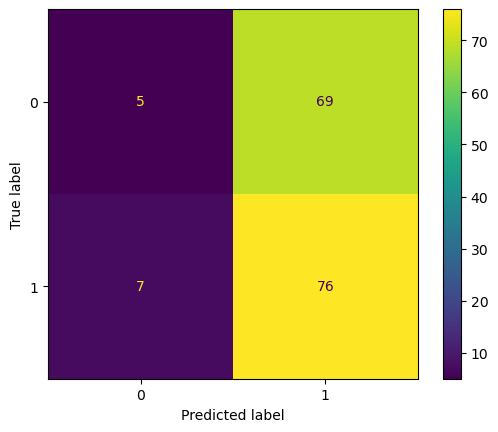

In [34]:
# get predictions from the model given the test set
y_pred = model1.predict(X_test)

# convert the predictions and test set to be in the shape of a vector of labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

create_confusion_matrix(y_test_labels, y_pred_labels)

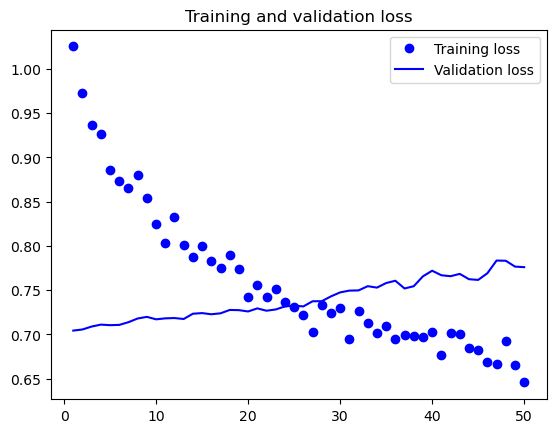

In [35]:
create_train_vald_graph(history.history)

In [36]:
# plot the model
plot_model(model1, show_shapes=True)

In [37]:
model1.summary()

Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)   │ (None, 6, 72)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer             │ [(None, 6, 6), (None, 6,  │               0 │ input_layer_18[0][0]       │
│ (InputSpiltLayer)             │ 30), (None, 6, 31),       │                 │                            │
│                               │ (None, 6, 5)]             │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_5            │ (None, 6, 32)             │             242 │ input_spilt_layer[0][0]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_7            │ (None, 6, 32)             │           1,082 │ input_spilt_layer[0][1]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_9            │ (None, 6, 32)             │           1,117 │ input_spilt_layer[0][2]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_11           │ (None, 6, 32)             │             207 │ input_spilt_layer[0][3]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_3            │ (None, 6, 32)             │           2,552 │ input_layer_18[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_23        │ (None, 6, 32)             │             128 │ separable_conv1d_5[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_31        │ (None, 6, 32)             │             128 │ separable_conv1d_7[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_39        │ (None, 6, 32)             │             128 │ separable_conv1d_9[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_47        │ (None, 6, 32)             │             128 │ separable_conv1d_11[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 6, 32)             │             12

 Total params: 1,939,124 (7.40 MB)

 Trainable params: 1,927,282 (7.35 MB)

 Non-trainable params: 11,840 (46.25 KB)

 Optimizer params: 2 (12.00 B)

# LSTM model

In [38]:

def create_lstm_model_branch(data_set_branch):
#     input_data = Input(shape=(data_set_branch.shape[1], data_set_branch[2]))
    
    y = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(data_set_branch)
    y = BatchNormalization()(y)
    # source: MaxPooling1D layer, https://keras.io/api/layers/pooling_layers/max_pooling1d/
    # Max pooling operation for 1D temporal data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides.
    y = MaxPooling1D()(y)
    
    x = LSTM(256, return_sequences=True)(y)
    x = BatchNormalization()(x)
    
    x = LSTM(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    x = LSTM(192, return_sequences=True, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)
    
    x = LSTM(64, return_sequences=True, recurrent_dropout=0.4)(x)
    x = BatchNormalization()(x)
    
    x = LSTM(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    y2 = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(x)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D()(y2)
    
    residual = add([y, y2])

    
    x = LSTM(160, return_sequences=False, recurrent_dropout=0.2)(residual)
    x = BatchNormalization()(x)
        
    return x
    
    
def create_LSTM_inception_model(_timesteps, X_train_shape):
    
    # add the model layers
    # input layer
    input_data = Input(shape=(_timesteps, X_train_shape[2]))
    
    full_features_branch = create_lstm_model_branch(input_data)
    
    # source of inspiration: deep learning with python, 7.1.4. Directed acyclic graphs of layers, Inception modules, https://www.manning.com/books/deep-learning-with-python
    data_set_branches = InputSpiltLayer([6, 36, 67, 72])(input_data)
    
    branch_1 = create_lstm_model_branch(data_set_branches[0])
    branch_2 = create_lstm_model_branch(data_set_branches[1])
    branch_3 = create_lstm_model_branch(data_set_branches[2])
    branch_4 = create_lstm_model_branch(data_set_branches[3])
    
    
    
    branches_merged = concatenate([branch_1, branch_2, branch_3, branch_4, full_features_branch], axis=-1)    
    
    output = Dense(2, activation='softmax')(branches_merged)
    
    # create the model
    model = Model(input_data, output)

    # compile the model
    optimizer = SGD(learning_rate=0.0019545050901889393)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['precision'])
    
    return model



# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[6]['ROP']['X_train'], timesteps_options_dict[6]['ROP']['y_train']
X_vald, y_vald = timesteps_options_dict[6]['ROP']['X_vald'], timesteps_options_dict[6]['ROP']['y_vald']
X_test, y_test = timesteps_options_dict[6]['ROP']['X_test'], timesteps_options_dict[6]['ROP']['y_test']

# initialize the model
model1 = create_LSTM_inception_model(6, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=50, batch_size=256, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

# list the model architecture
# model1.summary()

[0.723176896572113, 0.5031847357749939]

In [39]:
model1.evaluate(X_train, y_train, verbose=0)

[0.6952870488166809, 0.5083260536193848]

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


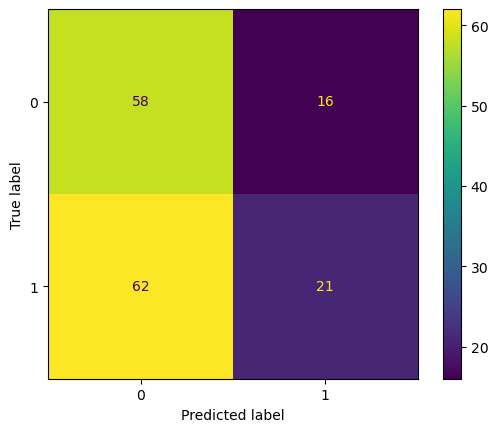

In [40]:
# get predictions from the model given the test set
y_pred = model1.predict(X_test)

# convert the predictions and test set to be in the shape of a vector of labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

create_confusion_matrix(y_test_labels, y_pred_labels)

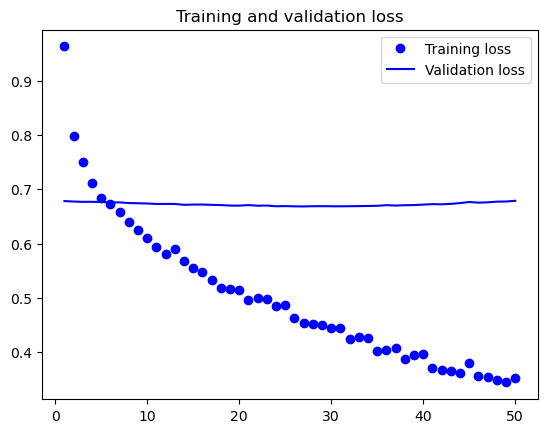

In [41]:
create_train_vald_graph(history.history)

In [42]:
# plot the model
plot_model(model1, show_shapes=True)

# GRU

In [43]:

def create_gru_model_branch(data_set_branch):
#     input_data = Input(shape=(data_set_branch.shape[1], data_set_branch[2]))
    
    y = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(data_set_branch)
    y = BatchNormalization()(y)
    # source: MaxPooling1D layer, https://keras.io/api/layers/pooling_layers/max_pooling1d/
    # Max pooling operation for 1D temporal data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides.
    y = MaxPooling1D()(y)
    
    x = GRU(256, return_sequences=True)(y)
    x = BatchNormalization()(x)
    
    x = GRU(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    x = GRU(192, return_sequences=True, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)
    
    x = GRU(64, return_sequences=True, recurrent_dropout=0.4)(x)
    x = BatchNormalization()(x)
    
    x = GRU(224, return_sequences=True, recurrent_dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    y2 = SeparableConv1D(filters=32, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              activation='relu')(x)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D()(y2)
    
    residual = add([y, y2])

    
    x = GRU(160, return_sequences=False, recurrent_dropout=0.2)(residual)
    x = BatchNormalization()(x)
        
    return x
    
    
def create_LSTM_inception_model(_timesteps, X_train_shape):
    
    # add the model layers
    # input layer
    input_data = Input(shape=(_timesteps, X_train_shape[2]))
    
    full_features_branch = create_gru_model_branch(input_data)
    
    # source of inspiration: deep learning with python, 7.1.4. Directed acyclic graphs of layers, Inception modules, https://www.manning.com/books/deep-learning-with-python
    data_set_branches = InputSpiltLayer([6, 36, 67, 72])(input_data)
    
    branch_1 = create_gru_model_branch(data_set_branches[0])
    branch_2 = create_gru_model_branch(data_set_branches[1])
    branch_3 = create_gru_model_branch(data_set_branches[2])
    branch_4 = create_gru_model_branch(data_set_branches[3])
    
    
    
    branches_merged = concatenate([branch_1, branch_2, branch_3, branch_4, full_features_branch], axis=-1)    
    
    output = Dense(2, activation='softmax')(branches_merged)
    
    # create the model
    model = Model(input_data, output)

    # compile the model
    optimizer = SGD(learning_rate=0.0019545050901889393)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['precision'])
    
    return model



# setup the data to be passed to the model
X_train, y_train = timesteps_options_dict[6]['ROP']['X_train'], timesteps_options_dict[6]['ROP']['y_train']
X_vald, y_vald = timesteps_options_dict[6]['ROP']['X_vald'], timesteps_options_dict[6]['ROP']['y_vald']
X_test, y_test = timesteps_options_dict[6]['ROP']['X_test'], timesteps_options_dict[6]['ROP']['y_test']

# initialize the model
model1 = create_LSTM_inception_model(6, X_train.shape)

# train the model
history = model1.fit(X_train, y_train, validation_data=(X_vald, y_vald), epochs=50, batch_size=256, verbose=0)


## Model evaluation and prototype conclusion

# test the model accuracy
model1.evaluate(X_test, y_test, verbose=0)

# list the model architecture
# model1.summary()

[1.0186798572540283, 0.4904458522796631]

In [44]:
model1.evaluate(X_train, y_train, verbose=0)

[0.7111309766769409, 0.510955274105072]

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


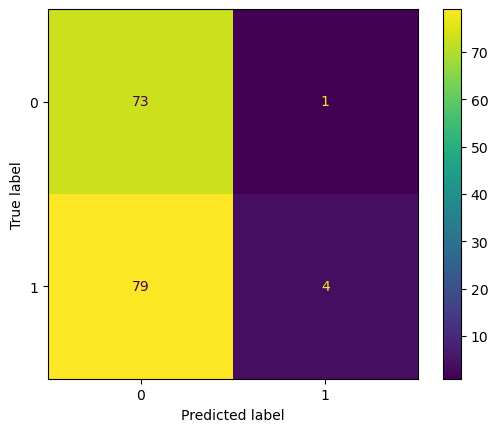

In [45]:
# get predictions from the model given the test set
y_pred = model1.predict(X_test)

# convert the predictions and test set to be in the shape of a vector of labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

create_confusion_matrix(y_test_labels, y_pred_labels)

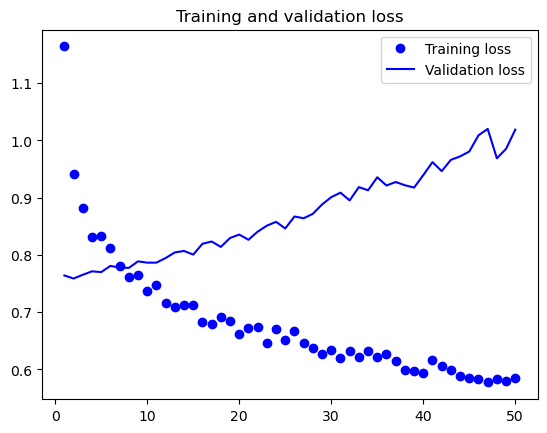

In [46]:
create_train_vald_graph(history.history)